# Clustering

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PROCESSED = "../data/processed/"
RAW = "../data/raw/"
RANDOM_STATE = 1

In [3]:
df_train = pd.read_csv(f"{PROCESSED}train_features.csv")

In [4]:
X_train = df_train.drop(columns=["Label"])
y_train = df_train["Label"]

In [5]:
print("Running K-Means clustering...")
kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init=10, max_iter=300)
cluster_labels = kmeans.fit_predict(X_train)

print("\n=== K-Means Clustering Results ===")
print(f"Number of clusters: 5")
print(f"Total samples: {len(cluster_labels)}")

silhouette_avg = silhouette_score(X_train, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

print("\n=== Label Distribution per Cluster ===")

df_clusters = pd.DataFrame({'Cluster': cluster_labels, 'Label': y_train})

counts = df_clusters.groupby(['Cluster', 'Label']).size().unstack(fill_value=0)

counts['Total'] = counts.sum(axis=1)

formatted_df = pd.DataFrame(index=counts.index)

for label in [0, 1]:
    formatted_df[label] = counts.apply(
        lambda row: f"{row[label]} ({row[label]/row['Total']*100:.1f}%)", 
        axis=1
    )

formatted_df['Total'] = counts['Total']

formatted_df.columns = ['Class 0', 'Class 1', 'Total Samples']

print(formatted_df)

Running K-Means clustering...

=== K-Means Clustering Results ===
Number of clusters: 5
Total samples: 50587
Silhouette Score: 0.0035

=== Label Distribution per Cluster ===
               Class 0        Class 1  Total Samples
Cluster                                             
0         3096 (36.9%)   5290 (63.1%)           8386
1           114 (5.2%)   2080 (94.8%)           2194
2        11521 (47.7%)  12627 (52.3%)          24148
3         8052 (81.8%)   1795 (18.2%)           9847
4         2426 (40.4%)   3586 (59.6%)           6012


In [6]:
# Load raw training texts for inspection
df_train_raw = pd.read_csv(f"{RAW}train.csv").reset_index(drop=True)
train_texts_raw = df_train_raw['Text'].tolist()
train_labels_raw = df_train_raw['Label'].tolist()

# Get centroids
centroids = kmeans.cluster_centers_

print("=" * 80)
print("Documents Closest to Each Centroid")
print("=" * 80)

num_closest = 3  # Number of valid closest documents to show

for cluster_id in range(5):
    centroid = centroids[cluster_id]
    
    # Calculate distances from all points to this centroid
    distances = cdist([centroid], X_train.values, metric='euclidean')[0]
    
    # Sort all document indices from closest to furthest
    sorted_indices = np.argsort(distances)
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*80}")
    
    # Cluster statistics
    cluster_mask = cluster_labels == cluster_id
    cluster_true_labels = y_train[cluster_mask]
    fake_count = np.sum(cluster_true_labels == 0)
    real_count = np.sum(cluster_true_labels == 1)
    
    print(f"\nCluster Statistics:")
    print(f"  Total documents in cluster: {np.sum(cluster_mask)}")
    print(f"  Fake news: {fake_count} ({fake_count/np.sum(cluster_mask)*100:.1f}%)")
    print(f"  Real news: {real_count} ({real_count/np.sum(cluster_mask)*100:.1f}%)")
    
    print(f"\n{num_closest} Closest Documents (Valid Texts Only):")
    print("-" * 80)
    
    # There were a lot of rows where text is "NONE". We considered those documents uninformative
    # and decided to only inspect those whose text was not "NONE"
    valid_count = 0
    for idx in sorted_indices:
        if valid_count >= num_closest:
            break
        
        # Check index bounds
        if idx >= len(train_texts_raw):
            continue
        
        text = train_texts_raw[idx]
        true_label = train_labels_raw[idx]
        
        # Skip missing, empty, or literal "NONE" texts
        if not isinstance(text, str) or len(text.strip()) == 0 or text.strip().upper() == "NONE":
            continue
        
        valid_count += 1
        
        print(f"\nDocument {idx}, Length: {len(text)}, (Distance: {distances[idx]:.2f}, Label: {'Fake' if true_label == 0 else 'Real'}):")
        print(f"{text}")

Documents Closest to Each Centroid

CLUSTER 0

Cluster Statistics:
  Total documents in cluster: 8386
  Fake news: 3096 (36.9%)
  Real news: 5290 (63.1%)

3 Closest Documents (Valid Texts Only):
--------------------------------------------------------------------------------

Document 931, Length: 17, (Distance: 0.34, Label: Fake):
"Fuck you Greta!"

Document 25447, Length: 30, (Distance: 0.34, Label: Fake):
"Problematizaram o cafézinho!"

Document 41275, Length: 36, (Distance: 0.34, Label: Fake):
"@atchouameni
@Camavinga
@KMbappe"

CLUSTER 1

Cluster Statistics:
  Total documents in cluster: 2194
  Fake news: 114 (5.2%)
  Real news: 2080 (94.8%)

3 Closest Documents (Valid Texts Only):
--------------------------------------------------------------------------------

Document 931, Length: 17, (Distance: 0.41, Label: Fake):
"Fuck you Greta!"

Document 41275, Length: 36, (Distance: 0.41, Label: Fake):
"@atchouameni
@Camavinga
@KMbappe"

Document 25447, Length: 30, (Distance: 0.41, Label:

## Visualization with PCA


PCA Explained Variance Ratio:
  PC1: 0.0091 (0.91%)
  PC2: 0.0086 (0.86%)
  Total: 0.0178 (1.78%)


/Users/guilherme/Desktop/faculdade/3anoMaterial/NTT-DATA-challenge/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


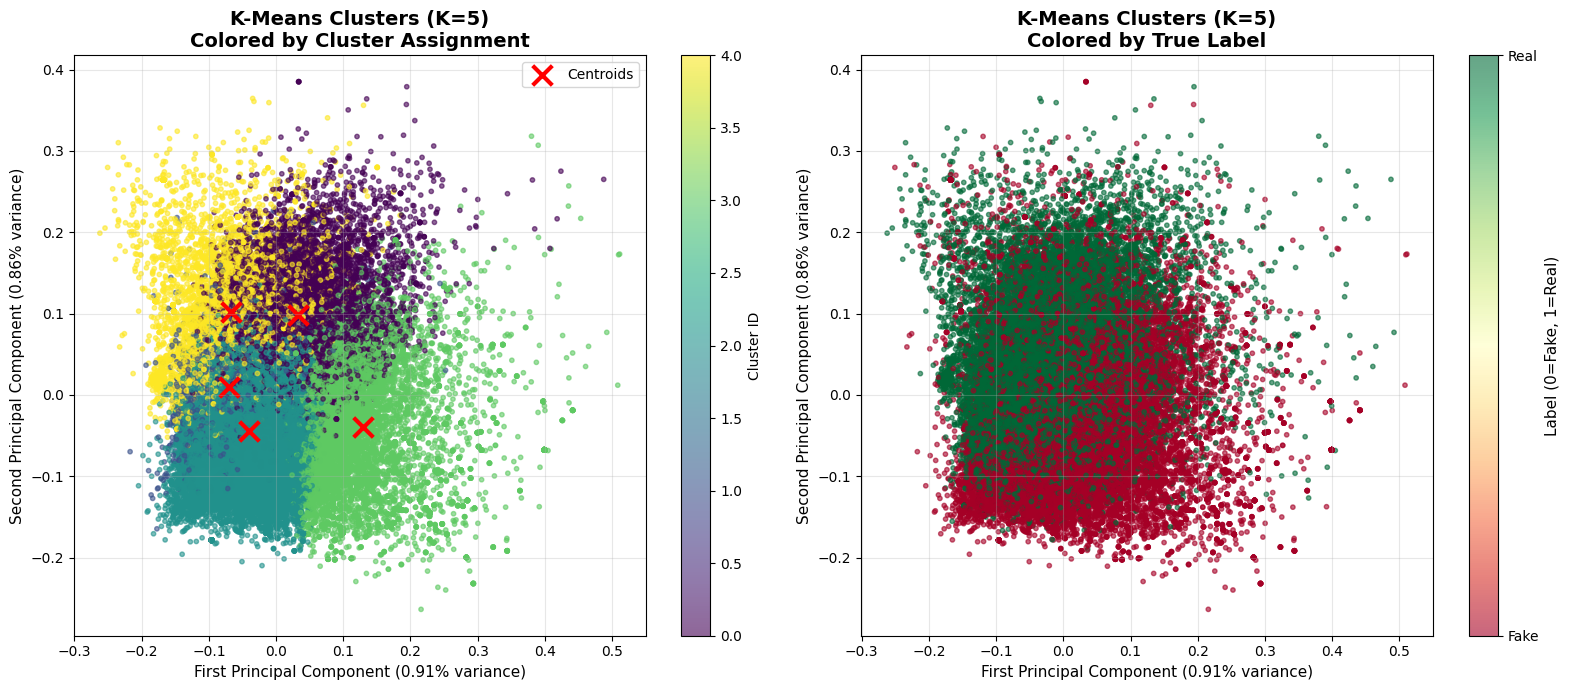


Cluster-Label Alignment Analysis

Cluster 0:
  Fake news: 36.9%
  Real news: 63.1%
  Purity: 63.1%

Cluster 1:
  Fake news: 5.2%
  Real news: 94.8%
  Purity: 94.8%

Cluster 2:
  Fake news: 47.7%
  Real news: 52.3%
  Purity: 52.3%

Cluster 3:
  Fake news: 81.8%
  Real news: 18.2%
  Purity: 81.8%

Cluster 4:
  Fake news: 40.4%
  Real news: 59.6%
  Purity: 59.6%


In [7]:
# Apply PCA to reduce to 2D
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_train)

print(f"PCA Explained Variance Ratio:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]*100:.2f}%)")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f} ({pca.explained_variance_ratio_[1]*100:.2f}%)")
print(f"  Total: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Colored by cluster assignment
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=10)
ax1.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=11)
ax1.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=11)
ax1.set_title('K-Means Clusters (K=5)\nColored by Cluster Assignment', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Cluster ID')

# Plot centroids
centroids_pca = pca.transform(centroids)
ax1.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='x', s=200, linewidths=3, label='Centroids')
ax1.legend()

# Plot 2: Colored by true label
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='RdYlGn', alpha=0.6, s=10)
ax2.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=11)
ax2.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=11)
ax2.set_title('K-Means Clusters (K=5)\nColored by True Label', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
cbar = plt.colorbar(scatter2, ax=ax2)
cbar.set_label('Label (0=Fake, 1=Real)', fontsize=11)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Fake', 'Real'])

plt.tight_layout()
plt.show()

# Analyze cluster-label alignment
print("\n" + "=" * 80)
print("Cluster-Label Alignment Analysis")
print("=" * 80)
for cluster_id in range(5):
    cluster_mask = cluster_labels == cluster_id
    cluster_true_labels = y_train[cluster_mask]
    fake_pct = np.sum(cluster_true_labels == 0) / len(cluster_true_labels) * 100
    real_pct = np.sum(cluster_true_labels == 1) / len(cluster_true_labels) * 100
    
    print(f"\nCluster {cluster_id}:")
    print(f"  Fake news: {fake_pct:.1f}%")
    print(f"  Real news: {real_pct:.1f}%")
    print(f"  Purity: {max(fake_pct, real_pct):.1f}%")